In [1]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
import pandas as pd
import numpy as np


data_path = 'features_annotated.csv'
df = pd.read_csv(data_path)

### Create a mapping for the URLs

In [3]:
urlSet = set()
for u in df['url'].values:
    urlSet.add(u)

url2Idx = {}
for url in urlSet:
    url2Idx[url] = len(url2Idx)

In [4]:
url2Idx

{'http://checkyourfact.com/2018/07/09/fact-check-nfl-ratings-20-percent/': 8,
 'http://www.politifact.com/personalities/sean-hannity/': 6,
 'https://africacheck.org/reports/eskom-and-the-viral-infographic-do-the-numbers-add-up/': 4,
 'https://fullfact.org/europe/uk-one-biggest-contributors-eu-budget/?utm_source=homepage&utm_medium=main_story': 3,
 'https://hoax-alert.leadstories.com/3469573-fake-news-florida-babysitter-tied-crying-one-month-old-baby-to-ceiling-fan-for-26-hours.html': 10,
 'https://pesacheck.org/have-58-of-ugandas-roads-been-built-using-only-government-money-e2156f2aa41a': 9,
 'https://theconversation.com/factcheck-is-australias-population-the-highest-growing-in-the-world-96523': 7,
 'https://theferret.scot/scotland-oil-abu-dhabi-dubai/': 5,
 'https://www.factcheck.org/2018/07/trumps-false-claims-at-nato/': 1,
 'https://www.snopes.com/fact-check/hillary-clinton-smash-phone-hammer/': 2,
 'https://www.washingtonpost.com/news/fact-checker/wp/2018/07/18/phil-bredesens-claim

### Create a mapping for the labels

In [5]:
labelSet = set()
for l in df['label'].values:
    labelSet.add(l)

label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)
labelEmbeddings = np.identity(len(label2Idx), dtype='float32')

In [6]:
label2Idx

{'Body': 4,
 'Claim': 0,
 'Credibility': 3,
 'Date': 2,
 'None': 6,
 'Sources': 1,
 'Title': 5}

### Create a mapping for the tags

In [7]:
tagSet = set()
for t in df['tag'].values:
    tagSet.add(t)

tag2Idx = {}
for tag in tagSet:
    tag2Idx[tag] = len(tag2Idx)
tagEmbeddings = np.identity(len(tag2Idx), dtype='float32')

In [8]:
tag2Idx

{'[document]': 55,
 'a': 48,
 'abbr': 1,
 'address': 25,
 'article': 34,
 'aside': 12,
 'author': 65,
 'b': 64,
 'base': 61,
 'blockquote': 63,
 'body': 37,
 'br': 68,
 'button': 66,
 'canvas': 20,
 'center': 9,
 'cite': 59,
 'detail': 6,
 'div': 52,
 'em': 40,
 'fieldset': 17,
 'figcaption': 39,
 'figure': 8,
 'footer': 24,
 'form': 69,
 'g': 49,
 'h1': 19,
 'h2': 41,
 'h3': 56,
 'h4': 26,
 'h5': 33,
 'h6': 31,
 'head': 11,
 'header': 51,
 'hr': 16,
 'html': 58,
 'i': 43,
 'iframe': 23,
 'img': 15,
 'input': 62,
 'ins': 10,
 'label': 27,
 'legend': 29,
 'li': 38,
 'link': 47,
 'main': 35,
 'meta': 32,
 'nav': 22,
 'noscript': 14,
 'ol': 54,
 'option': 60,
 'p': 67,
 'path': 42,
 'photo': 13,
 'section': 2,
 'select': 70,
 'sidebar': 30,
 'small': 71,
 'snippet': 3,
 'span': 5,
 'strong': 18,
 'style': 4,
 'sup': 44,
 'svg': 28,
 'symbol': 36,
 'text': 21,
 'textarea': 53,
 'time': 50,
 'title': 45,
 'u': 0,
 'ul': 46,
 'use': 7,
 'wp-ad': 57}

##### ToDo - Improve level feature representation

In [9]:
levelEmbeddings = np.identity(max(df['level'].values), dtype='float32')

### Data to features

In [10]:
columns = ['url', 'label', 'tag', 'level']  # 0 url  1 label

features = {'tags': [], 'levels': [], 'labels': [], 'groups': []}

In [11]:
for data in df[columns].values:
    features['groups'].append(url2Idx[data[0]])
    features['labels'].append(labelEmbeddings[label2Idx[data[1]]])
    features['tags'].append(tagEmbeddings[tag2Idx[data[2]]])
    features['levels'].append(levelEmbeddings[data[3]-1])
features['tags'] = np.array(features['tags'])
features['levels'] = np.array(features['levels'])
features['labels'] = np.array(features['labels'])
features['groups'] = np.array(features['groups'])

### Util - Plot confusion matrix

In [12]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Dense Model

In [13]:
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate


def dense_model():
    tag_input = Input(shape=(tagEmbeddings.shape[0],))
    tag_ = Dense(32, activation='relu')(tag_input)
    tag_ = Dense(16, activation='relu')(tag_)

    level_input = Input(shape=(levelEmbeddings.shape[0],))
    level_ = Dense(32, activation='relu')(level_input)
    level_ = Dense(16, activation='relu')(level_)

    output = concatenate([tag_, level_])
    output = Dense(32, activation='relu')(output)
    output = Dense(16, activation='relu')(output)
    output = Dense(len(label2Idx), activation='softmax')(output)

    model = Model(inputs=[tag_input, level_input], outputs=[output])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Cross Validation - Dense Model

In [34]:
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

gp = GroupKFold(n_splits=8)
for train_indexs, test_indexs in gp.split(features['tags'], groups=features['groups']):
    
    tags_train = features['tags'][train_indexs]
    levels_train = features['levels'][train_indexs]
    X_train = [tags_train, levels_train]
    y_train = features['labels'][train_indexs]
    
    tags_test = features['tags'][test_indexs]
    levels_test = features['levels'][test_indexs]
    X_test = [tags_test, levels_test]
    y_test = features['labels'][test_indexs]

    groups_train = features['groups'][train_indexs]
    groups_test = features['groups'][test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(g)
    for g in groups_test:
        test_g.add(g)
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    model = KerasClassifier(build_fn=dense_model)
    model.fit(X_train, y_train, epochs=5, verbose=0)

    result = model.predict(X_test)
    y_test = [r.tolist().index(1) for r in y_test]
    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    confusion.append(confusion_matrix(result, y_test))
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

Train Groups (URLs) {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {4}
Acc: 90.99 %
Precision: 25.60 %
Recall: 24.21 %
F1: 24.89 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 8, 9, 10}
Test Groups (URLs) {7}
Acc: 90.33 %
Precision: 28.28 %
Recall: 27.43 %
F1: 27.85 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 7, 8, 9, 10}
Test Groups (URLs) {6}
Acc: 96.19 %
Precision: 14.24 %
Recall: 13.78 %
F1: 14.01 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {1}
Acc: 84.45 %
Precision: 13.98 %
Recall: 12.29 %
F1: 13.08 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {2}
Acc: 95.92 %
Precision: 24.52 %
Recall: 21.11 %
F1: 22.50 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 7, 9}
Test Groups (URLs) {8, 10}
Acc: 89.11 %
Precision: 18.17 %
Recall: 20.02 %
F1: 18.63 %

Train Groups (URLs) {0, 1, 2, 4, 6, 7, 8, 9, 10}
Test Groups (URLs) {3, 5}
Acc: 88.72 %
Precision: 25.67 %
Recall: 19.54 %
F1: 21.62 %

Train Groups (URLs) {1, 2, 3, 4, 5, 6, 7, 8, 10}

###### Dense - Confusion Matrix plot

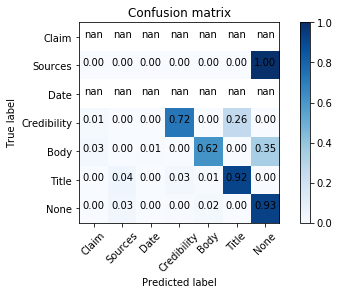

In [35]:
nc = []
for c in confusion:
    d = len(label2Idx) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, label2Idx.keys(), normalize=True)

### LSTM model

In [61]:
from keras.models import Model, Sequential
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate,Concatenate


def lstm_model_working():
    input_tags = Input(shape=(None, tagEmbeddings.shape[0]))
    lstm_tags = LSTM(150)(input_tags)
    output = Dense(len(label2Idx))(lstm_tags)
    model = Model(inputs=[input_tags], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model.summary()
    return model

def lstm_model():
    input_tags = Input(shape=(None, tagEmbeddings.shape[0]))
    lstm_tags = LSTM(150)(input_tags)
    
    input_levels = Input(shape=(None, levelEmbeddings.shape[0]))
    lstm_levels = LSTM(150)(input_levels)
    
    output = concatenate([lstm_tags, lstm_levels])
    output = Dense(len(label2Idx))(output)
    model = Model(inputs=[input_tags, input_levels], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model.summary()
    return model

#### Cross Validation - LSTM Model

In [66]:
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

gp = GroupKFold(n_splits=8)
for train_indexs, test_indexs in gp.split(features['tags'], groups=features['groups']):
    
    tags_train = features['tags'][train_indexs]
    tags_train = tags_train.reshape((tags_train.shape[0], 1, tags_train.shape[1])) # Test
    levels_train = features['levels'][train_indexs]
    levels_train = levels_train.reshape((levels_train.shape[0], 1, levels_train.shape[1])) # Test
    X_train = [tags_train, levels_train]
    y_train = features['labels'][train_indexs]
    
    tags_test = features['tags'][test_indexs]
    tags_test = tags_test.reshape((tags_test.shape[0], 1, tags_test.shape[1])) # Test
    levels_test = features['levels'][test_indexs]
    levels_test = levels_test.reshape((levels_test.shape[0], 1, levels_test.shape[1])) # Test
    X_test = [tags_test, levels_test]
    y_test = features['labels'][test_indexs]

    groups_train = features['groups'][train_indexs]
    groups_test = features['groups'][test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(g)
    for g in groups_test:
        test_g.add(g)
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    #model = KerasClassifier(build_fn=lstm_model)
    model.fit(X_train, y_train, epochs=5, verbose=0)
    #model.fit(tags_train, y_train, epochs=5, verbose=0)

    result = model.predict(X_test)
    #result = model.predict(tags_test)
    y_test = [r.tolist().index(1) for r in y_test]
    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    confusion.append(confusion_matrix(result, y_test))
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

Train Groups (URLs) {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {4}
Acc: 75.57 %
Precision: 12.52 %
Recall: 12.17 %
F1: 12.34 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 8, 9, 10}
Test Groups (URLs) {7}
Acc: 0.40 %
Precision: 1.53 %
Recall: 0.34 %
F1: 0.56 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 7, 8, 9, 10}
Test Groups (URLs) {6}
Acc: 96.48 %
Precision: 14.29 %
Recall: 13.78 %
F1: 14.03 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {1}
Acc: 86.29 %
Precision: 14.29 %
Recall: 12.33 %
F1: 13.23 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {2}
Acc: 56.56 %
Precision: 33.72 %
Recall: 15.99 %
F1: 13.79 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 7, 9}
Test Groups (URLs) {8, 10}
Acc: 88.68 %
Precision: 14.29 %
Recall: 12.67 %
F1: 13.43 %

Train Groups (URLs) {0, 1, 2, 4, 6, 7, 8, 9, 10}
Test Groups (URLs) {3, 5}
Acc: 34.32 %
Precision: 33.36 %
Recall: 15.19 %
F1: 12.49 %

Train Groups (URLs) {1, 2, 3, 4, 5, 6, 7, 8, 10}
Tes

###### LSTM - Confusion Matrix plot

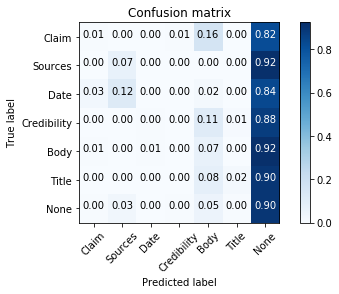

In [67]:
nc = []
for c in confusion:
    d = len(label2Idx) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, label2Idx.keys(), normalize=True)